# Feature engineering and selection

In [1]:
import pandas as pd
import numpy as np

from collections import defaultdict
from sklearn.cross_validation import StratifiedKFold
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import GridSearchCV
import pickle
import time
from sklearn.ensemble import *
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier

/usr/local/lib/python2.7/dist-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
#load the raw dataset

def load_data_set():
    train_data = pd.read_csv('train.csv')
    test = pd.read_csv('test.csv')
    test["outcome"] = 9
    bids = pd.read_csv('bids.csv')
    #bids = bids.sort(['auction', 'time'])
    return train_data,bids,test

train,bids,test = load_data_set()

In [9]:
'''
Alors fonction generer pour les bids l'ensemble des donnees suivantes : 
Pour chaque vente : temps moyen,max, std et min entre deux bids d une meme personne
                    temps moyen,max, st entre deux bids
                    nombre de bids max, min, et moyen de chaque utilisateur 
sauvegarde des resultats dans 3 csv differents
'''
def time_into_auction(train,bids,test):
    human = train[train.outcome==0].bidder_id
    bot = train[train.outcome==1].bidder_id
    grouped = bids.groupby('auction')
    done = -5
    #temps de bid par rapport aux dans une meme vente
    times_df = {}
    #temps de bid par rapport a soit meme pour chaque vente
    bid_himselft = {}
    #number of bids:
    number_bids = {}
    #wins auctions
    wins_auctions = {}
    moments_bids_final = {}
    remaining = len(grouped)
    difference=  [0,0]
    for bides in grouped:
        sub_data= bides[1]
        #sub_data.sort("time")
        last_bids = {}
        current_bids = {}
        start = 0
        end  = 0
        has_win = -1
        moments_bids = {}
        for acc in sub_data.iterrows():
            i,line = acc
            cle = line['bidder_id']
            if difference[0] == 0:
                difference[0] = line['time']
                start = line['time']
            else:
                if not cle in times_df:
                    times_df[cle] = []
                times_df[cle].append(line['time']-difference[0])
                difference[0] = line['time']
            if cle not in moments_bids:
                moments_bids[cle]= [line['time']]
            else:
                moments_bids[cle].append(line['time'])
            if cle not in last_bids:
                last_bids[cle] = (line['time'],[])
            else:
                last_bids[cle][1].append(line['time']-last_bids[cle][0])
                last_bids[cle] = (line['time'],last_bids[cle][1])
            if cle not in current_bids:
                current_bids[cle] = 1
            else:
                current_bids[cle] +=1
            end = line['time']
            has_win = cle
        #fusion des dictionnaires
        for c in current_bids:
            if not c in number_bids:
                number_bids[c] = [current_bids[c]]
            else:
                number_bids[c].append(current_bids[c])
        for c in last_bids:
            if not c in bid_himselft and len(last_bids[c][1])>0:
                bid_himselft[c] = last_bids[c]
            elif  len(last_bids[c][1])>0:
                bid_himselft[c] += last_bids[c]
        for c in moments_bids:
            if c not in moments_bids_final:
                moments_bids_final[c] = []
            moments_bids_final[c] += [((od-start)/float((end-start)+1.0)) for od in moments_bids[c]]
        loose = sub_data["bidder_id"].unique()
        for c in loose:
            if c not in wins_auctions:
                wins_auctions[c] = [0,0]
            wins_auctions[c][has_win==c] +=1
        if remaining %200 ==0:
            print("remaining : ", remaining)
        remaining -=1
    df = []
    for c in wins_auctions:
        wins_auctions[c] = wins_auctions[c][1] / float(np.sum(wins_auctions[c]))
    for cle in times_df.keys():
        df.append({'bidder_id': cle, 'mean_autres': np.mean(times_df[cle]),
    'min_autres': np.min(times_df[cle]), 'max_autres': np.max(times_df[cle]),'std_autres': np.std(times_df[cle])})
    pd.DataFrame(df).to_csv('res/time_auction.csv', index=False)
    df = []
    for cle in number_bids.keys():
        df.append({'bidder_id': cle, 'mean_number_bids': np.mean(number_bids[cle]),
    'min_number_bids': np.min(number_bids[cle]), 'max_number_bids': np.max(number_bids[cle]),
    'number_bids': len(number_bids[cle]),'std_number_bids': np.std(number_bids[cle])})
    pd.DataFrame(df).to_csv('res/bids_number.csv', index=False)
    df  = []
    for cle in bid_himselft.keys():
        val = bid_himselft[cle][1]
        df.append({'bidder_id': cle, 'mean_time_bids': np.mean(val),
    'min_time bids': np.min(val), 'max_time_bids': np.max(val),
    'number_of_auctions_bids': len(val),'std_time_bids': np.std(val)})
    pd.DataFrame(df).to_csv('res/himslef_time.csv', index=False)
    df  = []
    for cle in moments_bids_final.keys():
        #10 percent starting :
        #10 percent ending :
        starting = [(fre<0.1) for fre in moments_bids_final[cle]]
        ending = [(fre>0.9) for fre in moments_bids_final[cle]]
        #print(moments_bids_final[cle][moments_bids_final[cle]>0.10])
        df.append({'bidder_id': cle, 'average_moment_bid': np.mean(moments_bids_final[cle]),
    'std_moment_bid':np.std(moments_bids_final[cle]),'frequence_wind':wins_auctions[cle], 'starting_quick' : float(np.sum(starting))/float(len(starting)),
        'ending_quick' : float(np.sum(ending))/float(len(ending))})
    pd.DataFrame(df).to_csv('res/other_stats.csv', index=False)
    

recreate_feature = False
if recreate_feature:
    time_into_auction(train,bids,test)

In [4]:
import pickle
import os.path

#genere de nouvelles features relatives aux ips, pays et nombre de bids
def normalize(dicts):
    for c in dicts:
        tmp = dicts[c]
        total = float(np.sum(tmp))
        dicts[c] = (tmp[0]/total,tmp[1]/total)
    return dicts
# generate the features using the features created before
def feature_creation(train,test,bids):
    #number of differents ips,urls
    grouped = bids.groupby(['bidder_id','auction'])
    app_mean = grouped.device.nunique().groupby(level=0).mean()
    app_std = grouped.device.nunique().groupby(level=0).count()
    app_max = grouped.device.nunique().groupby(level=0).max()
    ip_mean = grouped.ip.nunique().groupby(level=0).mean()
    ip_std = grouped.ip.nunique().groupby(level=0).count()
    ip_max = grouped.ip.nunique().groupby(level=0).max()
    pays_mean = grouped.country.nunique().groupby(level=0).mean()
    pays_std = grouped.country.nunique().groupby(level=0).count()
    pays_max = grouped.country.nunique().groupby(level=0).max()
    page_mean = grouped.url.nunique().groupby(level=0).mean()
    page_std = grouped.url.nunique().groupby(level=0).count()
    page_max = grouped.url.nunique().groupby(level=0).max()
    df = []
    for cle in app_mean.keys():
        df.append({'bidder_id' : cle, 'app_mean': app_mean[cle], 'app_std': app_std[cle],
    'app_max': app_max[cle], 'ip_mean': ip_mean[cle],
    'ip_std': ip_std[cle],'ip_max': ip_max[cle],'pays_mean': pays_mean[cle],'pays_std': pays_std[cle],'pays_max': pays_max[cle],
    'page_mean': page_mean[cle],'page_std': page_std[cle],'page_max': page_max[cle]})
    pd.DataFrame(df).to_csv('res/nb_uniques.csv', index=False)
    df = []
    human = train[train.outcome==0]
    bots = train[train.outcome==1]
    human_bids = bids[bids["bidder_id"].isin(human["bidder_id"])]
    robot_bids = bids[bids["bidder_id"].isin(bots["bidder_id"])]
    show_stats = False
    if show_stats:
        import matplotlib.pyplot as plt
        import seaborn as sn
        %matplotlib inline
        countries = bids["country"].unique()
        for c in countries:
            sub_d_h= human_bids[human_bids["country"] == c]
            sub_d_r= robot_bids[robot_bids["country"] == c]
            if len(sub_d_r)>1:
                tmp_plot = sub_d_h.groupby("time").count()
                tmp_plot2 = sub_d_r.groupby("time").count()
                plt.plot(tmp_plot.index,tmp_plot,label="human",alpha=0.7)
                plt.plot(tmp_plot2.index,tmp_plot2,label="robot",alpha=0.7)
                plt.legend()
                plt.show()
    #average moment of biding in the auction and win percentage
    countries = {}
    urls = {}
    devices = {}
    ips = {}
    auctions = {}
    merchandises = {}
    times = {}
    if os.path.exists("stats/urls.pkl"):
        with open('stats/urls.pkl', 'rb') as handle:
            urls = pickle.load(handle)
        with open('stats/countries.pkl', 'rb') as handle:
            countries = pickle.load(handle)
        with open('stats/devices.pkl', 'rb') as handle:
            devices = pickle.load(handle)
        with open('stats/merchandises.pkl', 'rb') as handle:
            merchandises = pickle.load(handle)
        with open('stats/auctions.pkl', 'rb') as handle:
            auctions = pickle.load(handle)
        with open('stats/times.pkl', 'rb') as handle:
            times = pickle.load(handle)
        print(len(auctions),len(times),len(merchandises),len(devices),len(countries),len(urls))
    else:
        to_do = len(bids)
        bots_values = bots["bidder_id"].values
        #basics stats
        for i,acc in bids.iterrows():
            url = acc["url"]
            country = acc["country"]
            device = acc["device"]
            bid = acc["auction"]
            merchan = acc["merchandise"]
            time = acc["time"]
            cle = acc["bidder_id"]
            bot = cle in bots_values
            if url not in urls:
                urls[url] = [0,0]
            if country not in countries:
                countries[country] = [0,0]
            if device not in devices:
                devices[device] = [0,0]
            if bid not in auctions:
                auctions[bid] = [0,0]
            if merchan not in merchandises:
                merchandises[merchan] = [0,0]
            if time not in times:
                times[time] = [0,0]
            if bot:
                urls[url][0] +=1
                countries[country][0] +=1
                devices[device][0] +=1
                merchandises[merchan][0] +=1
                auctions[bid][0] +=1
                times[time][0] +=1
            else:
                urls[url][1] +=1
                countries[country][1] +=1
                devices[device][1] +=1
                merchandises[merchan][1] +=1
                auctions[bid][1] +=1
                times[time][1] +=1 
            to_do -= 1
            if to_do % 100000 ==0:
                print(to_do)
        urls = normalize(urls)
        countries = normalize(countries)
        devices = normalize(devices)
        merchandises = normalize(merchandises)
        auctions = normalize(auctions)
        times = normalize(times)
        with open('stats/urls.pkl', 'wb') as handle:
            pickle.dump(urls, handle, protocol=pickle.HIGHEST_PROTOCOL)
        with open('stats/countries.pkl', 'wb') as handle:
            pickle.dump(countries, handle, protocol=pickle.HIGHEST_PROTOCOL)
        with open('stats/devices.pkl', 'wb') as handle:
            pickle.dump(devices, handle, protocol=pickle.HIGHEST_PROTOCOL)
        with open('stats/merchandises.pkl', 'wb') as handle:
            pickle.dump(merchandises, handle, protocol=pickle.HIGHEST_PROTOCOL)
        with open('stats/auctions.pkl', 'wb') as handle:
            pickle.dump(auctions, handle, protocol=pickle.HIGHEST_PROTOCOL)
        with open('stats/times.pkl', 'wb') as handle:
            pickle.dump(times, handle, protocol=pickle.HIGHEST_PROTOCOL)
    grouped_person = bids.groupby(['bidder_id'])
    url_score = {}
    country_score = {}
    merchan_score = {}
    devices_score = {}
    auct_score = {}
    times_score = {}
    remaining = len(grouped_person)
    print("TO DO : ",remaining)
    bots_values = bots["bidder_id"].values
    for bides in grouped_person:
        sub_data= bides[1]
        for i,acc in sub_data.iterrows():
            cle = acc["bidder_id"]
            bot = cle in bots_values
            if cle not in url_score:
                url_score[cle] = urls[acc["url"]][int(bot)]
            if cle not in country_score:
                cle_c = acc["country"]
                if acc["country"] != "nan":
                    cle_c = "in"
                country_score[cle] = countries[cle_c][int(bot)]
            if cle not in merchan_score:
                merchan_score[cle] = merchandises[acc["merchandise"]][int(bot)]
            if cle not in devices_score:
                devices_score[cle] = devices[acc["device"]][int(bot)]
            if cle not in auct_score:
                auct_score[cle] = auctions[acc["auction"]][int(bot)]
            if cle not in times_score:
                times_score[cle] = times[acc["time"]][int(bot)]
        url_score[cle] = url_score[cle]  /float(len(sub_data))
        country_score[cle] = country_score[cle]  /float(len(sub_data))
        devices_score[cle] = devices_score[cle]  /float(len(sub_data))
        merchan_score[cle] = merchan_score[cle]  /float(len(sub_data))
        auct_score[cle] = auct_score[cle]  /float(len(sub_data))
        times_score[cle] = times_score[cle]  /float(len(sub_data))
        if remaining % 500 ==0:
            print(remaining)
        remaining -=1
    df  = []
    for cle in url_score.keys():
        df.append({'bidder_id' : cle, 'url_score': url_score[cle], 'country_score': country_score[cle],
    'device_score': devices_score[cle], 'merchan_score': merchan_score[cle],
    'zauc_score': auct_score[cle],'time_score': times_score[cle]})
    pd.DataFrame(df).to_csv('res/scores.csv', index=False)
    
    #to do : total number of bids, max nombre de bids dans une fentre de 15 minutes
    #nombre de bids pour chacun des jours
    '''
    heure moyen de bid
    number of simulatneous bids
    est ce que c'est une heire normale (calculer pour chaque pays fenetre la plus utilisee dans la journee)
    appartenir a url ? 'vasstdc27m7nks3(proba)
    '''
recreate = False
if recreate:
    feature_creation(train,test,bids)

In [76]:
# Generate new features :
from collections import Counter
def new_features(train,test,bids):
    countries= bids.country.unique()
    countries_nb = {}
    for c in countries:
        countries_nb[c] = bids[bids["country"] == c].bidder_id.value_counts()
    #consecutive bids
    tmp = bids.groupby(["bidder_id"]).time
    max_four = {}
    max_five= {}
    max_six = {}
    remaining = len(tmp)
    consevuctive_bids_mean = {}
    consevuctive_bids_min = {}
    consevuctive_bids_std = {}
    for d in tmp:
        cle = d[0]
        sub_data= d[1]
        sub_data.sort()
        four = np.max(Counter([str(nb)[:4] for nb in sub_data]).values())
        five = np.max(Counter([str(nb)[:5] for nb in sub_data]).values())
        six = np.max(Counter([str(nb)[:6] for nb in sub_data]).values())
        diff = np.ediff1d(sub_data)
        if len(diff)>0:
            consevuctive_bids_mean[cle] = np.mean(diff)
            consevuctive_bids_min[cle] = np.min(diff)
            consevuctive_bids_std[cle]= np.std(diff)
        max_four[cle] = four
        max_five[cle] = five
        max_six[cle] = six
        if remaining % 1000 ==0:
            print(remaining)
        remaining -=1
    ips_india_user = bids[(bids["country"] == "in")].groupby(["bidder_id"]).ip.nunique()
    ips_per_user = (bids.groupby(["bidder_id"]).ip.nunique())
    unique_time_user = (bids.groupby(["bidder_id"]).time.nunique())
    device_per_user = (bids.groupby(["bidder_id"]).device.nunique())
    url_per_user = (bids.groupby(["bidder_id"]).url.nunique())
    total_auction = bids.groupby("bidder_id").auction.count()
    total_bids = bids["bidder_id"].value_counts()
    #bid in each country
    merchandises = bids.merchandise.unique()
    merchan_nb = {}
    for m in merchandises:
        merchan_nb[m] = bids[bids["merchandise"] == m].bidder_id.value_counts()
    df = []
    for c in total_bids.keys():
        tmp = {'bidder_id' : c,  "ips_per_user" : ips_per_user[c], "device_user" : device_per_user[c],
                  "unq_time_user" : unique_time_user[c], "url_user" : url_per_user[c]}
        if c in ips_india_user:
            tmp["ips_india"] = ips_india_user[c]
        else:
            tmp["ips_india"] = 0
        if c in total_auction:
            tmp["total_ac"] = total_auction[c]
        else:
            tmp["total_ac"] = 0
        if c in total_bids:
            tmp["total_bids"] = total_bids[c]
        else:
            tmp["total_bids"] = 0
        for count in countries:
            if c in countries_nb[count]:
                tmp[str(count)] = countries_nb[count][c]
            else:
                tmp[str(count)] = 0
        for count in merchan_nb.keys():
            if c in merchan_nb[count]:
                tmp[str(count)] = merchan_nb[count][c]
            else:
                tmp[str(count)] = 0
        if c in consevuctive_bids_mean:
            tmp["consec_bids_mean"] = consevuctive_bids_mean[c]
            tmp["consec_bids_min"] = consevuctive_bids_min[c]
            tmp["consec_bids_std"] = consevuctive_bids_std[c]
        if c in max_four:
            tmp["max_four"] = max_four[c]
            tmp["max_five"] = max_five[c]
            tmp["max_six"] = max_six[c]
        df.append(tmp)
    pd.DataFrame(df).to_csv('res/newss_stats.csv', index=False)        

#new_features(train,test,bids)

In [3]:
#charge les fichiers contenant les features et fait une jointure sur l id des bidders
#on sauvegarde le train set et le test set dans un fichier csv
def load_all(train,test,bids):
    bids_numbers = pd.read_csv('res/bids_number.csv')
    himself_time = pd.read_csv('res/himslef_time.csv')
    other = pd.read_csv('res/other_stats.csv')
    scores = pd.read_csv('res/scores.csv')
    time_auction = pd.read_csv('res/time_auction.csv')
    nb_uniques = pd.read_csv('res/nb_uniques.csv')
    new_feats = pd.read_csv("res/newss_stats.csv")
    #test file
    y_train = train["outcome"]
    #new train representation
    new_train = train["bidder_id"].to_frame()
    new_train = pd.merge(new_train,bids_numbers,on="bidder_id",how="left")
    new_train = pd.merge(new_train,himself_time,on="bidder_id",how="left")
    new_train = pd.merge(new_train,other,on="bidder_id",how="left")
    new_train = pd.merge(new_train,scores,on="bidder_id",how="left")
    new_train = pd.merge(new_train,time_auction,on="bidder_id",how="left")
    new_train = pd.merge(new_train,nb_uniques,on="bidder_id",how="left")
    new_train = pd.merge(new_train,new_feats,on="bidder_id",how="left")
    new_train= new_train.fillna(new_train.mean())
    #new test
    new_test = test["bidder_id"].to_frame()
    new_test = pd.merge(new_test,bids_numbers,on="bidder_id",how="left")
    new_test = pd.merge(new_test,himself_time,on="bidder_id",how="left")
    new_test = pd.merge(new_test,other,on="bidder_id",how="left")
    new_test = pd.merge(new_test,scores,on="bidder_id",how="left")
    new_test = pd.merge(new_test,time_auction,on="bidder_id",how="left")
    new_test = pd.merge(new_test,nb_uniques,on="bidder_id",how="left")
    new_test = pd.merge(new_test,new_feats,on="bidder_id",how="left")
    new_test= new_test.fillna(new_test.mean())
    #new_train = new_train.drop("max_number_bids",axis=1)
    #new_test = new_test.drop("max_number_bids",axis=1)
    new_train = new_train.drop(["time_score","url_score","merchan_score","zauc_score","device_score","country_score"],axis=1)
    new_test = new_test.drop(["time_score","url_score","merchan_score","zauc_score","device_score","country_score"],axis=1)
    to_drop = ["pays_max","min_number_bids","pays_max"]
    new_train = new_train.drop(to_drop,axis=1)
    new_test = new_test.drop(to_drop,axis=1)
    return new_train,new_test,y_train

def test_loading(train,test,bids):
    time_auction = pd.read_csv('res/time_auction.csv')
    auctions_stats = pd.read_csv('res/stats_test.csv')
    auctions_stats_simple = pd.read_csv("res/stats_test_simple.csv")
    auctions_stats = auctions_stats.groupby('bidder_id',as_index=False).mean()
    '''print(auctions_stats.bidder_id)
    print(auctions_stats_simple.bidder_id)
    auctions_stats.rename(columns=lambda x: x+str("_c"), inplace=True)
    auctions_stats.rename(columns={"bidder_id_c":"bidder_id"},inplace=True)'''
    auctions_stats = pd.merge(auctions_stats,time_auction,on="bidder_id")
    auctions_stats_simple = pd.merge(auctions_stats_simple,auctions_stats,on="bidder_id")
    new_train = train[["bidder_id","outcome"]].copy()
    #y_train = train["outcome"]
    new_test = test[["bidder_id"]].copy()
    new_train = pd.merge(new_train,auctions_stats_simple,on="bidder_id")
    y_train = new_train["outcome"]
    #new_train = new_train.drop("outcome",axis=1)
    new_test = pd.merge(new_test,auctions_stats_simple,on="bidder_id")
    #new_test= new_test.fillna(mean_s)
    #new_train= new_train.fillna(mean_s)
    return new_train,new_test,y_train

X_train,X_test,y_train = test_loading(train,test,bids)
print(X_test.bidder_id.unique().shape)
print(X_train.bidder_id.unique().shape)
#X_trXain,X_test,y_train = load_all(train,test,bids)

(4630,)
(1984,)


In [5]:
X_train.to_csv("debug_train.csv",index=False)
X_test.to_csv("debug_test.csv",index=False)

In [4]:
train = pd.read_csv("debug_train.csv")
train['outcome'] = train['outcome'].astype(int)
ytrain = train['outcome']
train.drop('outcome', 1, inplace=True)
train.drop(labels=['bidder_id'], axis=1, inplace=True)
test = pd.read_csv("debug_test.csv")

# Grid search :

Gradient boosting classifier : 

In [13]:
from sklearn.ensemble import GradientBoostingClassifier
def grid_seach(train,ytrain):
    model = GradientBoostingClassifier(max_features=50,random_state=9) 
    parameters = {'n_estimators':[50,100,200,300], 'max_depth':[3,5,7,9],'learning_rate':[0.01,0.03,0.05,0.1]}
    clf = GridSearchCV(model, parameters,cv=10,n_jobs=-1,scoring='roc_auc')
    clf.fit(train, y_train)
    print(clf.best_score_)
    print(clf.best_params_)
    with open('mode_res_GradientBoostingClassifier.pickle', 'wb') as handle:
        pickle.dump(clf.grid_scores_, handle, protocol=pickle.HIGHEST_PROTOCOL)
grid_seach(train,ytrain)

0.926312387539
{'n_estimators': 200, 'learning_rate': 0.1, 'max_depth': 9}


/usr/local/lib/python2.7/dist-packages/sklearn/model_selection/_search.py:662: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


AdaBoostClassifier :

In [14]:
from sklearn.ensemble import AdaBoostClassifier
def grid_seach(train,ytrain):
    model = AdaBoostClassifier(random_state=9) 
    parameters = {'n_estimators':[50,100,200,300],'learning_rate':[0.01,0.03,0.05,0.1,0.3,0.7,1.0,1.5,2.0]}
    clf = GridSearchCV(model, parameters,cv=10,n_jobs=-1,scoring='roc_auc')
    clf.fit(train, y_train)
    print(clf.best_score_)
    print(clf.best_params_)
    with open('mode_res_AdaBoostClassifier.pickle', 'wb') as handle:
        pickle.dump(clf.grid_scores_, handle, protocol=pickle.HIGHEST_PROTOCOL)
grid_seach(train,ytrain)

0.922930538219
{'n_estimators': 200, 'learning_rate': 0.03}


/usr/local/lib/python2.7/dist-packages/sklearn/model_selection/_search.py:662: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


KNN : 

In [16]:
from sklearn.neighbors import KNeighborsClassifier
def grid_seach(train,ytrain):
    model = KNeighborsClassifier(n_jobs=-1) 
    parameters = {'n_neighbors':[1,3,5,10],'algorithm':['auto', 'ball_tree', 'kd_tree', 'brute']}
    clf = GridSearchCV(model, parameters,cv=10,n_jobs=-1,scoring='roc_auc')
    clf.fit(train, y_train)
    print(clf.best_score_)
    print(clf.best_params_)
grid_seach(train,ytrain)

/usr/local/lib/python2.7/dist-packages/sklearn/externals/joblib/parallel.py:540: UserWarning: Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
  **self._backend_args)
/usr/local/lib/python2.7/dist-packages/sklearn/externals/joblib/parallel.py:540: UserWarning: Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
  **self._backend_args)
/usr/local/lib/python2.7/dist-packages/sklearn/externals/joblib/parallel.py:540: UserWarning: Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
  **self._backend_args)
/usr/local/lib/python2.7/dist-packages/sklearn/externals/joblib/parallel.py:540: UserWarning: Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
  **self._backend_args)


0.781051604324
{'n_neighbors': 10, 'algorithm': 'auto'}


Xgboost : 

In [25]:
import xgboost
from sklearn.ensemble import AdaBoostClassifier
def grid_seach(train,ytrain):
    model = xgboost.XGBClassifier()
    parameters = {'max_depth': [3,6,10],  "n_estimators" : [50,100]}#,"gamma" : np.logspace(-3,0,10)}
    clf = GridSearchCV(model, parameters,cv=10,n_jobs=-1,scoring='roc_auc',verbose=2)
    clf.fit(train, y_train)
    print(clf.best_score_)
    print(clf.best_params_)
    with open('mode_res_XGBClassifier.pickle', 'wb') as handle:
        pickle.dump(clf.grid_scores_, handle, protocol=pickle.HIGHEST_PROTOCOL)
grid_seach(train,ytrain)

Fitting 10 folds for each of 6 candidates, totalling 60 fits
[CV] n_estimators=50, max_depth=3 ....................................
[CV] n_estimators=50, max_depth=3 ....................................
[CV] n_estimators=50, max_depth=3 ....................................
[CV] n_estimators=50, max_depth=3 ....................................
[CV] ........................... n_estimators=50, max_depth=3 -   0.2s
[CV] n_estimators=50, max_depth=3 ....................................
[CV] ........................... n_estimators=50, max_depth=3 -   0.2s
[CV] n_estimators=50, max_depth=3 ....................................
[CV] ........................... n_estimators=50, max_depth=3 -   0.1s
[CV] n_estimators=50, max_depth=3 ....................................
[CV] ........................... n_estimators=50, max_depth=3 -   0.1s
[CV] n_estimators=50, max_depth=3 ....................................
[CV] ........................... n_estimators=50, max_depth=3 -   0.2s
[CV] n_estimator

[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed: 10.6min


[CV] .......................... n_estimators=100, max_depth=6 -   0.1s
[CV] n_estimators=100, max_depth=6 ...................................
[CV] .......................... n_estimators=100, max_depth=6 -   0.1s
[CV] n_estimators=100, max_depth=6 ...................................
[CV] .......................... n_estimators=100, max_depth=6 -   0.2s
[CV] n_estimators=100, max_depth=6 ...................................
[CV] .......................... n_estimators=100, max_depth=6 -   0.2s
[CV] n_estimators=50, max_depth=10 ...................................
[CV] .......................... n_estimators=100, max_depth=6 -   0.2s
[CV] n_estimators=50, max_depth=10 ...................................
[CV] .......................... n_estimators=100, max_depth=6 -   0.1s
[CV] n_estimators=50, max_depth=10 ...................................
[CV] .......................... n_estimators=100, max_depth=6 -   0.2s
[CV] n_estimators=50, max_depth=10 ...................................
[CV] .

[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed: 26.5min finished


0.920764204344
{'n_estimators': 50, 'max_depth': 6}


/usr/local/lib/python2.7/dist-packages/sklearn/model_selection/_search.py:662: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


In [4]:
# first ml algo
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import RFECV


def to_kaggle(X_train,X_test,y_train):
    test_ids = X_test['bidder_id']
    X_test = X_test.drop(labels=['bidder_id'], axis=1, inplace=False)
    predictions = predict(X_train, X_test, y_train)
    sub = pd.read_csv('sampleSubmission.csv')
    result = pd.DataFrame()
    result['bidder_id'] = test_ids
    result['outcome'] = predictions
    sub = sub.merge(result, on='bidder_id', how='left')
    # Fill missing values with mean
    sub.fillna(0.0511674, inplace=True)
    sub.drop('prediction', 1, inplace=True)
    sub.to_csv('submission/random.csv', index=False, header=['bidder_id', 'prediction'])

def predict(X_train, X_test, y_train):
    clf = RandomForestClassifier(n_estimators=160,max_depth=8, max_features = 35 , random_state=9,criterion='entropy')
    clf.fit(X_train, y_train)
    predictions = clf.predict_proba(X_test)[:, 1]
    return predictions

def predict_model(X_train, X_test, y_train,model):
    model.fit(X_train, y_train)
    predictions = model.predict_proba(X_test)[:, 1]
    return predictions

def cross_val_score(train,ytrain):
    kf = StratifiedKFold(y=ytrain, n_folds=10)
    scores = []
    for train_index, test_index in kf:
        X_train, X_test = train.iloc[train_index], train.iloc[test_index]
        y_train, y_test = ytrain.iloc[train_index], ytrain.iloc[test_index]
        predictions = predict(X_train, X_test, y_train)
        scores.append(roc_auc_score(y_test, predictions))
    print np.mean(scores)
def grid_seach(train,ytrain):
    model = RandomForestClassifier(max_depth=8,random_state=9,criterion='entropy') 
    parameters = {'n_estimators':[50,100,150,200,250,300], 'max_features':[6,8,10,20,25,30,25,40,45,50,60,70,80]}
    clf = GridSearchCV(model, parameters,cv=10,n_jobs=-1,scoring='roc_auc')
    clf.fit(train, y_train)
    print(clf.best_score_)
    print(clf.best_params_)
    with open('mode_res.pickle', 'wb') as handle:
        pickle.dump(clf.grid_scores_, handle, protocol=pickle.HIGHEST_PROTOCOL)

def test_models(train,ytrain):
    kf = StratifiedKFold(y=ytrain, n_folds=10)
    models = [RandomForestClassifier(n_estimators=160,max_depth=8, max_features = 35 , random_state=9,criterion='entropy'),AdaBoostClassifier(),
             GradientBoostingClassifier(),KNeighborsClassifier(),AdaBoostClassifier(base_estimator=RandomForestClassifier(n_estimators=200,max_depth=8, max_features = 35 , random_state=9,criterion='entropy')),
             SVC(kernel="poly",probability=True),SVC(probability=True),DecisionTreeClassifier()]
    res_per_models = {}
    for m in models:
        print("-------------------------")
        print(str(m))
        start = time.time()
        scores = []
        for train_index, test_index in kf:
            X_train, X_test = train.iloc[train_index], train.iloc[test_index]
            y_train, y_test = ytrain.iloc[train_index], ytrain.iloc[test_index]
            predictions = predict_model(X_train, X_test, y_train,m)
            scores.append(roc_auc_score(y_test, predictions))
        print np.mean(scores)
        end = time.time()
        res_per_models[str(m)] = (np.mean(scores),end)
    with open('multi_modles.pickle', 'wb') as handle:
        pickle.dump(res_per_models, handle, protocol=pickle.HIGHEST_PROTOCOL)

def train_size_impact(train,ytrain):
    model = RandomForestClassifier(n_estimators=160,max_depth=8, max_features = 35 , random_state=9,criterion='entropy')
    res_per_models = []
    taille = np.linspace(0.15,1,15)
    for t in taille:
        print("-------------------------")
        start = time.time()
        scores = []
        X_tmp = train.copy()
        X_tmp["ppppp"] = ytrain
        X_tmp = X_tmp.sample(n=int(len(ytrain)*t))
        y_tmp = X_tmp["ppppp"]
        X_tmp = X_tmp.drop("ppppp",axis=1)
        kf = StratifiedKFold(y=y_tmp, n_folds=10)
        for train_index, test_index in kf:
            X_train, X_test = X_tmp.iloc[train_index], X_tmp.iloc[test_index]
            y_train, y_test = y_tmp.iloc[train_index], y_tmp.iloc[test_index]
            predictions = predict_model(X_train, X_test, y_train,model)
            scores.append(roc_auc_score(y_test, predictions))
        print np.mean(scores)
        res_per_models.append(np.mean(scores))
    with open('modele_percent.pickle', 'wb') as handle:
        pickle.dump(res_per_models, handle, protocol=pickle.HIGHEST_PROTOCOL)

'''
kf = StratifiedKFold(y=ytrain, n_folds=10)
scores = []
for train_index, test_index in kf:
    X_train, X_test = train.iloc[train_index], train.iloc[test_index]
    y_train, y_test = ytrain.iloc[train_index], ytrain.iloc[test_index]
    predictions = predict(X_train, X_test, y_train)
    scores.append(roc_auc_score(y_test, predictions))
print np.mean(scores)'''
#grid_seach(train,ytrain)
#to_kaggle(train,test,ytrain)
#test_models(train,ytrain)
#train_size_impact(train,ytrain)

'\nkf = StratifiedKFold(y=ytrain, n_folds=10)\nscores = []\nfor train_index, test_index in kf:\n    X_train, X_test = train.iloc[train_index], train.iloc[test_index]\n    y_train, y_test = ytrain.iloc[train_index], ytrain.iloc[test_index]\n    predictions = predict(X_train, X_test, y_train)\n    scores.append(roc_auc_score(y_test, predictions))\nprint np.mean(scores)'

In [14]:
from sklearn.model_selection import cross_val_predict
clf = RandomForestClassifier(n_estimators=160,max_depth=8, max_features = 35 , random_state=9,criterion='entropy')
y_pred = cross_val_predict(clf, train, ytrain,method='predict_proba')[:, 1]

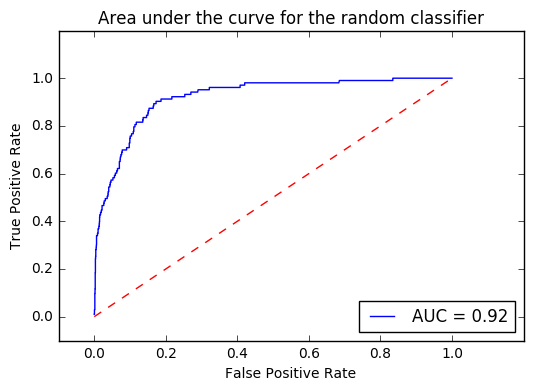

In [18]:
#affiche l'aire sous la courbe pour un random forest classifier
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
false_positive_rate, true_positive_rate, thresholds = roc_curve(ytrain, y_pred)
roc_auc = auc(false_positive_rate, true_positive_rate)
plt.title('Area under the curve for the random classifier')
plt.plot(false_positive_rate, true_positive_rate, 'b',
label='AUC = %0.2f'% roc_auc)
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')
plt.xlim([-0.1,1.2])
plt.ylim([-0.1,1.2])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

Feature ranking:


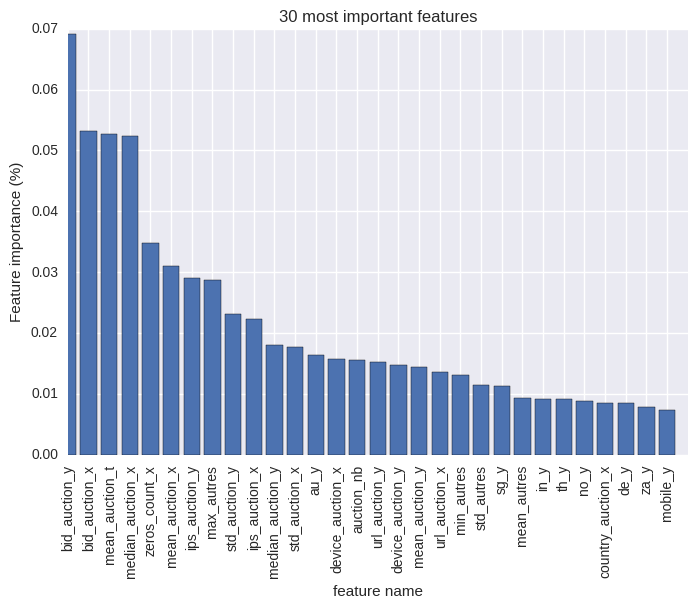

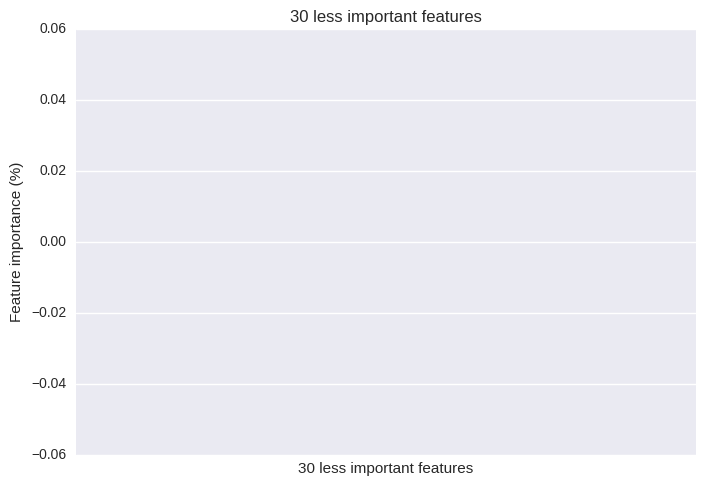

In [25]:
#affiche les 30 features les plus importantes et les 30 les moins importantes
import matplotlib.pyplot as plt
import seaborn as sn
clf = RandomForestClassifier(n_estimators=160,max_depth=8, max_features = 35 , random_state=9,criterion='entropy')
clf.fit(train, ytrain)
importances = clf.feature_importances_
std = np.std([tree.feature_importances_ for tree in clf.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")

'''for f in range(train.shape[1]):
    print("%d. feature %d (%f)" % (f + 1, indices[f], importances[indices[f]]))
'''
# Plot the feature importances of the forest
plt.figure()
plt.title("30 most important features")
#N most important features
N  = 30
#N_1 less important features
N_1 = 30
plt.bar(range(train.shape[1])[:N], importances[indices][:N],
       align="center")
names = train.columns
plt.xticks(range(train.shape[1])[:N], [names[i] for i in indices[:N]],rotation=90)
plt.xlim([0, N])
plt.xlabel("feature name")
plt.ylabel("Feature importance (%)")
plt.show()
#les important features
plt.figure()
plt.title("30 less important features")
plt.bar(range(train.shape[1])[-N_1:], importances[indices][-N_1:],
       align="center")
plt.xticks(range(train.shape[1])[-N_1:], indices[-N_1:],rotation=90)
plt.xlim([0, N_1])
plt.xlabel("30 less important features")
plt.ylabel("Feature importance (%)")
plt.show()

In [4]:
#ancien code pour creer des features
from tools import *

def stats_country(sub_data,line):
    dicts = sub_data['merchandise'].value_counts()
    for typ, value in dicts.iteritems():
        line[typ] = value
    for c in sub_data['country'].unique():
        line[str(c)] = 1
def test_apply(data):
    line = {"test" : 5}
    return pd.Series(line)
def basic_stats(sub_data):
    t1 = sub_data.shape
    return t1[0]
def features_times(bids):
    #tmp_copye = bids.copy()
    #tmp_copye = tmp_copye[tmp_copye["bidder_id"]=="0051aef3fdeacdadba664b9b3b07e04e4coc6"]
    bidders = bids.groupby(['bidder_id', 'auction'])
    df = []
    for bid in bidders:
        sub_data = bid[1]
        time_moving = np.ediff1d(sub_data['time'])
        if len(time_moving)>0:
            min_v = np.min(time_moving)
            mean_v = np.mean(time_moving)
            std_v = np.std(time_moving)
            median_v = np.median(time_moving)
            zeros_count = len(time_moving) - np.count_nonzero(time_moving)
        else:
            min_v,mean_v,std_v,median_v,zeros_count = 0.0,0.0,0.0,0.0,0.0
        line = dict.fromkeys(categories, 0)
        line.update(dict.fromkeys(countries_list, 0))
        line["bidder_id"] = bid[0][0]
        line["auction"] = bid[0][1]
        #line["min_auction"] = min_v
        line["mean_auction"] = mean_v
        line["std_auction"] = std_v
        line["median_auction"] = median_v
        line["zeros_count"] = zeros_count
        #ips
        line['ips_auction'] = basic_stats(sub_data['ip'].unique())
        #urls
        line['url_auction'] = basic_stats(sub_data['url'].unique())
        #device
        line['device_auction'] = basic_stats(sub_data['device'].unique())
        #countries
        line['country_auction'] = basic_stats(sub_data['country'].unique())
        #bids
        line['bid_auction'] = sub_data.shape[0]
        #merchandises
        line['merchan_auction'] = basic_stats(sub_data['merchandise'].unique())
        stats_country(sub_data,line)
        df.append(line)
    pd.DataFrame(df).to_csv('res/stats_test.csv',index=False)
    
def features_times_simple(bids):
    bids = pd.read_csv('bids.csv')
    #tmp_bids = bids.copy()
    #tmp_bids = tmp_bids[tmp_bids["bidder_id"]=="fa64831ab5ade55daee13f852c16b0a84ujt0"]
    bidders = bids.groupby(['bidder_id'])
    df = []
    for bid in bidders:
        #print(np.mean(np.ediff1d((bid[1].time))))
        sub_data = bid[1]
        time_moving = np.ediff1d(sub_data['time'])
        if len(time_moving)>0:
            min_v = np.min(time_moving)
            mean_v = np.mean(time_moving)
            std_v = np.std(time_moving)
            median_v = np.median(time_moving)
            zeros_count = len(time_moving) - np.count_nonzero(time_moving)
        else:
            min_v,mean_v,std_v,median_v,zeros_count = 0.0,0.0,0.0,0.0,0.0
        line = dict.fromkeys(categories, 0)
        line.update(dict.fromkeys(countries_list, 0))
        line["bidder_id"] = bid[0]
        #line["min_auction"] = min_v
        line["mean_auction"] = mean_v
        line["std_auction"] = std_v
        line["median_auction"] = median_v
        line["zeros_count"] = zeros_count
        #ips
        line['ips_auction'] = basic_stats(sub_data['ip'].unique())
        #urls
        line['url_auction'] = basic_stats(sub_data['url'].unique())
        #device
        line['device_auction'] = basic_stats(sub_data['device'].unique())
        #countries
        line['auction_nb'] = sub_data['auction'].unique().shape[0]
        line['country_auction'] = basic_stats(sub_data['country'].unique())
        #bids
        line['bid_auction'] = sub_data.shape[0]
        #merchandises
        line['merchan_auction'] = basic_stats(sub_data['merchandise'].unique())
        stats_country(sub_data,line)
        line['mean_auction_t'] = np.mean(sub_data['auction'].value_counts())
        df.append(line)
    pd.DataFrame(df).to_csv('res/stats_test_simple.csv',index=False)

recreate= False
if recreate:
    features_times(bids)
recreate2 = True
if recreate2:
    features_times_simple(bids)